In [76]:
import numpy as np
import re, csv, nltk
import pandas as pd
pd.options.mode.chained_assignment = None 

less_than = ['mediocre compared to','flat throw','low','worse in','worst'
             'bad at','worse than','sssllllloooowwww','heavy','heavier',
             'heaviest','slower','slow','lack','sacrifice','less','lesser',
             'lower','not as','least','expensive','little fast for','not spinny enough',
             'too ','absorbing a lot of the spin potential']

greater = ['thinner','thiner','miles ahead','lasts','last longer','lasting','bouncier','good for','good deal of',
           'prefer','appreciate','enough','thicker','firmer','higher throw',
'easier to','nice','great','fine for looping','medium-high throw','high throw',
'faster','spinnier','spinner','shorter trajectory','speedy','plent speed','spinney','spiny','spinny','speedier',
'spinnier','keeps on spinning','massive spin','monster spin','extreme','fast spins','fast spin','faster',
'better','plenty of','heavy spin','good control','good spin','good speed','cheaper',
'generate tons of spin','fast','insensitive to spin','good grip','grippier','quicker',
'more','better','higher','easier','softer','faster','excellent','light','ligter','lightest',
           'tacky','extremely fast','hardest','harder','best','driving']

equal = ['pretty close','fairly close','comparable','similar','equal','same','equivalent',
         'ok speed','same as','so so','as good as','equally',
        'little difference','could cope with','outclasses','very much like','closer to',
         'similiar','not much different','no big difference']

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def assign_comparative(sentences_df,less_than=less_than,greater=greater,equal=equal):
    
    def assign_words(sentences_df,words,category):
            sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains(words),category] = 1            
        
    assign_words(sentences_df,'spin|rotate','spin')
    assign_words(sentences_df,'fast|speed|slow','speed')
    assign_words(sentences_df,'hard|soft','hardness')
    assign_words(sentences_df,'tack|grip|sticky','tackiness') #stiff not useful- usually stiff blades
    assign_words(sentences_df,'control','control')
    assign_words(sentences_df,'bounc|lively','bounce')
    assign_words(sentences_df,'arc|angle|throw|flat|high arc|high throw','throw')
    assign_words(sentences_df,'durable|last long|long last','durability')
    assign_words(sentences_df,'for block','blocking')
    assign_words(sentences_df,'for loop|driv','looping')
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains\
                     ('Spin Spiel Ultima|backspin|T88 Ultra Spin|geospin|spinmax|topspin|underspin|\-spin')\
                     ,'spin'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('\-soft|\-hard'),'hardness'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('throw it|throw away'),'throw'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('speed glue|Rapid Speed'),'speed'] = 0
    sentences_df = sentences_df.fillna(0)
    
    
    # this part is for getting multiple word labels
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]

    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('less')
                word_list.append(lesser_word)
        for greater_word in greater:
            location = sentence.find(greater_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('better')
                word_list.append(greater_word)
        for equal_word in equal:
            location = sentence.find(equal_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('equal')
                word_list.append(equal_word)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
    
    # this is good for having only one aspect in the sentence
    sentences_df['comparative_word_begin_idx_first'] = -1000
    
    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1:
                sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                sentences_df.loc[idx,'comparative_first'] = 'less'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first']== -1000:
            for greater_word in greater:
                location = sentence.find(greater_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'better'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first'] == -1000:
            for equal_word in equal:
                location = sentence.find(equal_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'equal'
                    
    sentences_df['specific_aspects_cnt'] = sentences_df['spin']+sentences_df['speed']+\
                                        sentences_df['hardness']+sentences_df['tackiness']+\
                                        sentences_df['control']+sentences_df['bounce']+\
                                        sentences_df['throw']+sentences_df['durability']+\
                                        sentences_df['blocking']+sentences_df['looping']

    sentences_df.loc[(sentences_df['specific_aspects_cnt']!=1)&\
                     (sentences_df['comparative_first'].isna()==False),'overall'] = 1

    sentences_df['overall'] = sentences_df['overall'].fillna(0)

    sentences_df['all_aspects_cnt'] = sentences_df['specific_aspects_cnt'] + sentences_df['overall']
    
    all_labeled = sentences_df # [(sentences_df['comparative_word_begin_idx_first']!=-1000)]
    
    return all_labeled


def do_the_thing(fn):
       
    df_raw = pd.read_csv(fn,index_col=0)
    df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_raw.dropna()    
    # select out only comparative and descriptive comments
    df = df_raw[(df_raw['classification']=='comparative') | (df_raw['classification']=='descriptive')]     
    
    # filter out sentences with question mark
    df = df[~df['reply_split'].str.lower().str.contains('?',regex=False)]
    
    # substitute rubber names, identify relevant rubbers
    # at present, just identify those in the rubber dictionary
    df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)

    df = assign_comparative(df)
    
    return df, df_raw


In [77]:
df, df_raw = do_the_thing('../Comparison/final_eval_2.csv')

df_comp = df[df['classification']=='comparative']
df_desc = df[df['classification']=='descriptive']

In [78]:
def print_row_info(row, ind):
    print('====================')    
    print('[{0}] {1}'.format(ind, row.reply_split))
    print('  aspects: {0}'.format(find_aspects(row)))
    print('  rubbers: {0}'.format(row.entity))
    print('  comparative relation: {0}'.format(row.comparative))     
    print('  comparative words: {0}'.format(row.comparative_words))
    print('  thread title: {0}'.format(row.thread_title))
    #print(row.entity_locs)
    #print(row.comparative_word_begin_idx)

def find_aspects(row):
    col_names = row.index[8:18]
    return [s for s in col_names[row[col_names]!=0]]

def contains_rub(entity, rub_name):
    for e in entity:
        if rub_name.lower() in e.lower():
            return True
    return False

In [79]:
for ind, row in df_comp.iterrows():
    if row['specific_aspects_cnt']==1:
        asp = find_aspects(row)[0]
        num_entity = len(set(row.entity))
        if num_entity > 0 and contains_rub(row.entity,'Tenergy'):
            if num_entity == 2 & len(row.comparative_words) > 0:
                print_row_info(row, ind)
                if row.entity_locs[0] < row.entity_locs[1]:
                    A = row.entity[0]
                    B = row.entity[1]
                else:
                    B = row.entity[0]
                    A = row.entity[1]                    
                print('  identification: {0} - {1} - {2} - {3}'.format(asp,A,row.comparative_words[0],B))
            


[1234] 05 feels a bit harder to me than this rubber,64 feels softer.
  aspects: ['hardness']
  rubbers: ['Butterfly-Tenergy-05', 'Butterfly-Tenergy-64']
  comparative relation: ['better', 'better']
  comparative words: ['softer', 'harder']
  thread title: Tibhar Evolution MX-P vs Butterfly Tenergy 64
  identification: hardness - Butterfly-Tenergy-05 - softer - Butterfly-Tenergy-64
[2119] t64 dosent have a softer sponge, have the same one as t05, but the wider spaced pips gives a softer felling , and t64 is ligther cause have less pips...
  aspects: ['hardness']
  rubbers: ['Butterfly-Tenergy-64', 'Butterfly-Tenergy-05', 'Butterfly-Tenergy-64']
  comparative relation: ['less', 'better', 'equal']
  comparative words: ['less', 'softer', 'same']
  thread title: Modern defender - Tenergy 05 vs Tenergy 64
  identification: hardness - Butterfly-Tenergy-64 - less - Butterfly-Tenergy-05
[3071] The Rakza felt mushy, way too soft and horrible compared to the harder more positive direct feeling 05

In [9]:
# get a sense of what rubber comparisons are worth making

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def accum_col(df):
    p = []
    df.apply(lambda l: p.extend(set(l)))
    return p

def plot_most_bar(p,num):
    most = Counter(p).most_common()

    x, y = [], []
    for word,count in most[:num]:
        x.append(word)
        y.append(count)

    plt.figure(figsize=(15,3*num/10.0))
    ax = sns.barplot(x=y,y=x)    
    

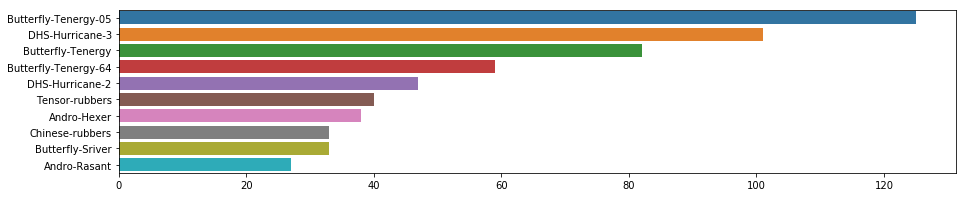

In [10]:
plot_most_bar(accum_col(df_comp['entity']),10)

# Try separating out the comparative words to identify aspect simultaneously

In [217]:
import numpy as np
import re, csv, nltk
import pandas as pd
pd.options.mode.chained_assignment = None 

aspects = ['spin','speed','hardness','tackiness','weight','control','throw angle','durability','blocking','looping']
sw = [None]*len(aspects)
lt, gt, eq = [None]*len(aspects), [None]*len(aspects), [None]*len(aspects)
# spin
sw[0]='spin|rotate'
lt[0]=['not as spin','not spinny enough','less spin','harder to spin',
       'harder to put spin','not spinny enough','absorbing a lot of the spin potential']
gt[0]=['spinnier','more spin','spinner','spinier','generate tons of spin']
eq[0]=['as spinny as']
# speed
sw[1]='fast|speed|slow|bounc|lively'
lt[1]=['not as fast','not as bounc','slower','slow','sssllllloooowwww','less lively']
gt[1]=['not as slow','faster','bouncier','quicker','speedier','livelier']
eq[1]=['as fast as','as slow as','as bouncy as']
# hardness
sw[2]='hard|soft'
lt[2]=['softer','not as hard']
gt[2]=['firmer','harder','hardest','not as soft']
eq[2]=['as hard as','as soft as']
# tackiness
sw[3]='tack|grip|sticky'
lt[3]=['not as stick','not as tack','not as grip']
gt[3]=['tackier','stickier','good grip','grippier']
eq[3]=['as sticky as','as grippy as','as tacky as']
# weight
sw[4]='heav|light|weigh'
lt[4]=['not as heavy','ligter','lightest']
gt[4]=['not as light','heavier','heaviest']
eq[4]=['as heavy as','as light as']
# control
sw[5]='control'
lt[5]=['not as easy to control','not as much control','harder to control','worse control']
gt[5]=['more control','easier to control','better control','good control','more control']
eq[5]=['as easy to control','as good control']
# throw angle
sw[6]='arc|angle|throw|flat|high arc|high throw'
lt[6]=['not as high','flat throw',' lower','lower throw','shorter trajectory']
gt[6]=['not as low','higher','higher throw','longer trajectory','medium-high throw']
eq[6]=['similar throw']
# durability
sw[7]='durable|last long|long last'
lt[7]=['lifetime is shorter','shorter lifetime','chips away']
gt[7]=['lifetime is longer','longer lifetime','more durable','lasts longer']
eq[7]=['last as long as','lasts as long as','as durable as']
# blocking
sw[8]='for block'
lt[8]=[]
gt[8]=[]
eq[8]=[]
# driving
sw[9]='for loop|for driv'
lt[9]=[]
gt[9]=[]
eq[9]=[]

less_than = ['mediocre compared to','low','worse in','worst'
             'bad at','worse than',
             'lack','sacrifice','less','lesser',
             'not as','least',
             'too ','not as good compared to']

greater = ['miles ahead','good for','greater deal of',
           'prefer','thicker','firmer',
           'easier','nicer','greater','speedy','plent speed','spinney','spiny','spinny',
           'better','more','better','easier','best','outclasses']

equal = ['pretty close','fairly close','comparable','similar','equal','same','equivalent',
         'same as','so so','as good as','equally',
        'little difference','could cope with','very much like','closer to','close to',
        'similiar','not much different','no big difference']

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def sub_and_find_rubbers(s):
    sub = sub_rubber_names(s)
    words = word_process(sub)
    entity, entity_locs = find_rubbers(words)    
    return sub, words, entity, entity_locs

def assign_comparative(sentences_df,less_than=less_than,greater=greater,equal=equal):
    
    def assign_words(sentences_df,words,category):
            sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains(words),category] = 1            
          
    for i,asp in enumerate(aspects):
        assign_words(sentences_df,sw[i],asp)
    
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains\
                     ('Spin Spiel Ultima|backspin|T88 Ultra Spin|geospin|spinmax|topspin|underspin|\-spin')\
                     ,'spin'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('\-soft|\-hard'),'hardness'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('throw it|throw away'),'throw'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('speed glue|Rapid Speed'),'speed'] = 0
    sentences_df = sentences_df.fillna(0)
    
    
    # 
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]    
    sentences_df['comparative_words'] = [[]] * sentences_df.shape[0]        
    sentences_df['comparative_aspects'] = [[]] * sentences_df.shape[0]        
    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        comp_asp_list = []
        for i, asp in enumerate(aspects):
            for lesser_word in lt[i]:
                location = sentence.find(lesser_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('less')
                    word_list.append(lesser_word)
                    comp_asp_list.append(asp)
            for greater_word in gt[i]:
                location = sentence.find(greater_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('better')
                    word_list.append(greater_word)
                    comp_asp_list.append(asp)
            for lesser_word in lt[i]:
                location = sentence.find(lesser_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('less')
                    word_list.append(lesser_word)
                    comp_asp_list.append(asp)                    
            for equal_word in eq[i]:
                location = sentence.find(equal_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('equal')
                    word_list.append(equal_word)  
                    comp_asp_list.append(asp)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
        sentences_df.at[idx,'comparative_aspects'] = comp_asp_list
        
        
                    
    sentences_df['specific_aspects_cnt'] = sentences_df['spin']+sentences_df['speed']+\
                                        sentences_df['hardness']+sentences_df['tackiness']+\
                                        sentences_df['control']+sentences_df['weight']+\
                                        sentences_df['throw']+sentences_df['durability']+\
                                        sentences_df['blocking']+sentences_df['looping']

#    sentences_df.loc[(sentences_df['specific_aspects_cnt']!=1)&\
#                     (sentences_df['comparative_first'].isna()==False),'overall'] = 1

#    sentences_df['overall'] = sentences_df['overall'].fillna(0)

#    sentences_df['all_aspects_cnt'] = sentences_df['specific_aspects_cnt'] + sentences_df['overall']
    
    all_labeled = sentences_df # [(sentences_df['comparative_word_begin_idx_first']!=-1000)]
    
    return all_labeled


def do_the_thing(fn):
       
    df_raw = pd.read_csv(fn,index_col=0)
    df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_raw.dropna()    
    # select out only comparative and descriptive comments
    df = df_raw[(df_raw['classification']=='comparative') | (df_raw['classification']=='descriptive')]     
    
    # filter out sentences with question mark
    df = df[~df['reply_split'].str.lower().str.contains('?',regex=False)]
    
    # substitute rubber names, identify relevant rubbers
    # at present, just identify those in the rubber dictionary
    #df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    #df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    #df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)
    df[['reply_sub','reply_words','entity','entity_locs']] = \
                        df['reply_split'].apply(sub_and_find_rubbers).apply(pd.Series)

    df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)    
    
    df = assign_comparative(df)
    
    return df, df_raw


In [218]:
df, df_raw = do_the_thing('../Comparison/final_eval_3.csv')

df_comp = df[df['classification']=='comparative']
df_desc = df[df['classification']=='descriptive']

In [219]:
def print_row_info(row, ind):
    print('====================')    
    print('[{0}] {1}'.format(ind, row.reply_split))
    print('  aspects: {0}'.format(find_aspects(row)))
    print('  rubbers: {0}'.format(row.entity))
    print('  comparative relation: {0}'.format(row.comparative))     
    print('  comparative words: {0}'.format(row.comparative_words))
    print('  comparative aspects: {0}'.format(row.comparative_aspects))    
    print('  thread title: {0}'.format(row.thread_title))
    #print(row.entity_locs)
    #print(row.comparative_word_begin_idx)

def find_aspects(row):
    col_names = row.index[8:18]
    return [s for s in col_names[row[col_names]!=0]]

def contains_rub(entity, rub_name):
    for e in entity:
        if rub_name.lower() in e.lower():
            return True
    return False

In [220]:
# find immediately preceding index
def find_immed_preceding(loc_list, loc):
    if len(loc_list) > 0:
        loc_sorted = np.sort(loc_list)
        ind = -1
        for i,l in enumerate(loc_sorted):
            if loc > l:
                ind = i
            else:
                break
        if ind == -1:
            return -1
        else:
            return np.where(np.argsort(loc_list)==ind)[0][0]
    else:
        return -1

def find_other_ent(ent_list, ent):
    for e in ent_list:
        if e != ent:
            return e
    return None


In [221]:
for ind, row in df_comp.iterrows():
    if len(row['comparative_words'])>0:
        #asp = find_aspects(row)[0]
        num_entity = len(set(row.entity))
        if num_entity > 0:
            if num_entity == 2 & len(row.comparative_words) > 0:
                print_row_info(row, ind)
                print('  thread title: {0}'.format(sub_and_find_rubbers(row.thread_title)[0]))               
                for w,l,a in zip(row.comparative,row.comparative_word_begin_idx,row.comparative_aspects):
                    ent_ind = find_immed_preceding(row.entity_locs,l)
                    if ent_ind > -1:
                        print('  almighty comparison: {0} -- {1} -- {2} -- {3}'.format(a,row.entity[ent_ind],w,find_other_ent(row.entity,row.entity[ent_ind])))
                    else:
                        print('  almighty comparison:')

[215]    The difference in spin between mx-p and mx-p50 is not really huge, it's just that mxp50 feels slightly more stable on higher effort strokes with quicker arm speed, basically if you've felt like the ball slightly slips orrr doesn't grip well on the reg mx-p, then mx-p 50 would do a lot better on those strokes.
  aspects: ['spin', 'speed', 'tackiness', 'weight']
  rubbers: ['Tibhar-Evolution-MX-P', 'Tibhar-Evolution-MX-P-50', 'Tibhar-Evolution-MX-P', 'Tibhar-Evolution-MX-P-50']
  comparative relation: ['better', 'better']
  comparative words: ['quicker', 'higher']
  comparative aspects: ['speed', 'throw angle']
  thread title: MX-P 50 Vs Tenergy 05 Hard
  thread title: Tibhar-Evolution-MX-P-50 Vs Butterfly-Tenergy-05-Hard
  almighty comparison: speed -- Tibhar-Evolution-MX-P-50 -- better -- Tibhar-Evolution-MX-P
  almighty comparison: throw angle -- Tibhar-Evolution-MX-P-50 -- better -- Tibhar-Evolution-MX-P
[216] The low throw along with the added stability let's you really swi

[7435] MXP seems a touch faster and harder new than 05 and the arc you get on the ball is generally lower than with 05 (I play with Viscaria) I haven't tried mxp on an all wood blade but I did try 05 on a korbel and it was fantastic.
  aspects: ['speed', 'hardness', 'throw angle']
  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05', 'Butterfly-Tenergy-05', 'Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['better', 'better', 'less']
  comparative words: ['faster', 'harder', ' lower']
  comparative aspects: ['speed', 'hardness', 'throw angle']
  thread title: T05 vs MXP
  thread title: Butterfly-Tenergy-05 vs Tibhar-Evolution-MX-P
  almighty comparison: speed -- Tibhar-Evolution-MX-P -- better -- Butterfly-Tenergy-05
  almighty comparison: hardness -- Tibhar-Evolution-MX-P -- better -- Butterfly-Tenergy-05
  almighty comparison: throw angle -- Butterfly-Tenergy-05 -- less -- Tibhar-Evolution-MX-P
[7440] This feels a little softer, higher throw, not quite 

  comparative aspects: ['speed', 'speed']
  thread title: Rasant Powergrip Vs MX-P
  thread title: Andro-Rasant-PowerGrip Vs Tibhar-Evolution-MX-P
  almighty comparison:
  almighty comparison:
[13405]    i tried h3n and h8 in red and black i think black h3n is alittle firmer and harder than the red and more durable also as regard spin i think they r the same .
  aspects: ['spin', 'hardness', 'durability']
  rubbers: ['DHS-Hurricane-3-National', 'DHS-Hurricane-8', 'DHS-Hurricane-3-National']
  comparative relation: ['better', 'better', 'better']
  comparative words: ['firmer', 'harder', 'more durable']
  comparative aspects: ['hardness', 'hardness', 'durability']
  thread title: Is black Hurricane 3 Neo spinnier than red??
  thread title: Is black DHS-Hurricane-3 Neo spinnier than red??
  almighty comparison: hardness -- DHS-Hurricane-3-National -- better -- DHS-Hurricane-8
  almighty comparison: hardness -- DHS-Hurricane-3-National -- better -- DHS-Hurricane-8
  almighty comparison: du

In [ ]:
## graveyard for now    
    
    # this part is for getting multiple word labels
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]

    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('less')
                word_list.append(lesser_word)
        for greater_word in greater:
            location = sentence.find(greater_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('better')
                word_list.append(greater_word)
        for equal_word in equal:
            location = sentence.find(equal_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('equal')
                word_list.append(equal_word)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
    
    # this is good for having only one aspect in the sentence
    sentences_df['comparative_word_begin_idx_first'] = -1000
    
    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1:
                sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                sentences_df.loc[idx,'comparative_first'] = 'less'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first']== -1000:
            for greater_word in greater:
                location = sentence.find(greater_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'better'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first'] == -1000:
            for equal_word in equal:
                location = sentence.find(equal_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'equal'
